In [5]:
import numpy as np
import colocationship as cl
import copy
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
df = pd.read_hdf('/scratch/share/datasets/a21/a21_checkins_30k_users.h5', key='table')

In [7]:
df_network = pd.read_hdf('/scratch/share/datasets/a21/a21_checkins_with_network.h5', key='table')

In [8]:
egolist = list(set(df_network['user_id'].tolist()))
alterlist = list(set(df_network['tgt'].tolist()))

In [9]:
print(len(egolist), len(alterlist))

35338 3534518


In [10]:
df_part = df_network[df_network['tgt'].isin(egolist)]

In [11]:
df_friend = df_part[['user_id', 'tgt']]

# What is Friendship Network (reciprocal friendships)

In [12]:
df_A = df_part.copy()
df_B = df_part.copy()

In [13]:
df_A = df_A.rename(columns={"user_id": "userid_x", "tgt": "userid_y"})
df_B = df_B.rename(columns={"user_id": "userid_y", "tgt": "userid_x"})

In [14]:
df_inner = pd.merge(df_A, df_B, on =['userid_x', 'userid_y'])

In [15]:
df_reciprocal = df_inner.groupby(by=['userid_x', 'userid_y']).size().reset_index(name='N_contact')

More than 15 reciprocal contact

In [16]:
df_reciprocal_valid  = df_reciprocal[df_reciprocal['N_contact']>=15]

In [17]:
len(set(df_reciprocal_valid['userid_x'].tolist()))

16221

In [18]:
df_friend  = df_reciprocal_valid[['userid_x', 'userid_y']]

In [19]:
df_friend

,userid_x,userid_y
0,0002D18309AF4230C09139D2FBB59E72,3BA8D5135A90138C4E6362AE76C782A6
1,0002D18309AF4230C09139D2FBB59E72,449F84BCECF4268C339AC12CC27FFBCD
2,0002D18309AF4230C09139D2FBB59E72,5672F56621984155A125C65413703167
8,0002D18309AF4230C09139D2FBB59E72,EDBA2EEBAD0BD771EE6AF192584996D1
9,0002D18309AF4230C09139D2FBB59E72,F0ED8A818412FF5672D37C0CA4A5C14F
...,...,...
121412,FFFC7713CD9614B5463E72F394A62B2A,3EE58F151BC2732AE94BD5AD8E0A84D2
121414,FFFC7713CD9614B5463E72F394A62B2A,4ADA7A1B6930BC124EE46E9F9168D02B
121416,FFFC7713CD9614B5463E72F394A62B2A,752200F7D3D26E9054F0B5898A53D87D
121417,FFFC7713CD9614B5463E72F394A62B2A,7E5012C68BDB1E25BE1996C549323FBF


# DF checkins

In [20]:
df_checkin = df_part[['user_id', 'lat', 'lon', 'location_id', 'created_at']].copy()

In [21]:
df_checkin.columns = ['userid', 'lat', 'lon', 'placeid', 'datetime']

In [22]:
df_checkin

,userid,lat,lon,placeid,datetime
2,0002D18309AF4230C09139D2FBB59E72,-22.70589,-43.29072,322,2014-01-09 12:03:14
3,0002D18309AF4230C09139D2FBB59E72,-22.70589,-43.29072,322,2014-01-09 12:21:56
6,0002D18309AF4230C09139D2FBB59E72,-22.70589,-43.29072,322,2014-01-09 16:25:26
7,0002D18309AF4230C09139D2FBB59E72,-22.70589,-43.29072,322,2014-01-09 16:31:49
11,0002D18309AF4230C09139D2FBB59E72,-22.72407,-43.31827,1169,2014-01-09 17:22:55
...,...,...,...,...,...
22116204,FFFE9D2D90DC0169BDD243FA2276D569,-22.88160,-43.57130,172,2014-06-23 11:56:29
22116205,FFFE9D2D90DC0169BDD243FA2276D569,-22.88160,-43.57130,172,2014-06-23 12:11:20
22116207,FFFE9D2D90DC0169BDD243FA2276D569,-22.87065,-43.55858,178,2014-06-23 12:15:46
22116219,FFFE9D2D90DC0169BDD243FA2276D569,-22.94383,-43.18235,963,2014-06-24 09:43:16


# Let's Focus on Main Results

In [26]:
co_locationship = cl.Co_Locationship(df_checkin, mins_records=150, missing='-')

In [27]:
print('There are', co_locationship.pdata['userid'].count(), 'valid check-ins records, \n'
      'There are', co_locationship.pdata['userid'].nunique(), 'valid users, \n'
      'There are', co_locationship.pdata['placeid'].nunique(), 'distinct placeid. \n'
     )

There are 1382626 valid check-ins records, 
There are 4415 valid users, 
There are 1816 distinct placeid. 



In [28]:
# # First time, should run co_locationship
# placeidT = co_locationship()

# cl.util.save_object(placeidT, 'BZR_placeidT_150.pickle')

placeidT = cl.util.read_object("BZR_placeidT_150.pickle")
co_locationship.placeidT = placeidT

In [29]:
# # Run in the first time (it takes 30 mins)
# cln = co_locationship.build_network(freq='H')
# cln.to_csv('BZR_raw_meetup_150.csv', index=False)

co_locationship.network = pd.read_csv('BZR_raw_meetup_150.csv')

In [30]:
print(co_locationship.network['userid_x'].nunique(), co_locationship.network['userid_y'].nunique())

4415 4415


In [31]:
# # Run in the first time (it takes 6 hours)
# cln_details = co_locationship.calculate_info()
# cln_details.to_csv('BZR_CLN_CE_info_150.csv', index=False)

co_locationship.network_details = pd.read_csv('BZR_CLN_CE_info_150.csv')

In [32]:
print(co_locationship.network_details['userid_x'].nunique(), 
      co_locationship.network_details['userid_y'].nunique())

4415 4415


In [33]:
cln_filtered = co_locationship.network_control(quality=True, 
                                contribution=True, 
                                num_alters=10, 
                                by=['userid_x', 'meetup', 'N_previous'], 
                                ascending=[True, False, True],
                                N_previous=150)

In [34]:
print(cln_filtered['userid_x'].nunique(), cln_filtered['userid_y'].nunique())

3608 4346


In [35]:
# # Run in the first time (it takes 4 hour)
# co_locationship.calculate_network(verbose=False, filesave=True, name='BZR')

# The second time, you can just read the saved result
co_locationship.network_details = pd.read_csv('BZR_CLN_network_details_H.csv')
co_locationship.final_userlist = sorted(list(set(co_locationship.network_details['userid_x'].tolist())))

# Social-Relationship Network Experiment

In [36]:
social_relationship = cl.Social_Relationship(df_checkin,df_friend, 
                                             mins_records=150, 
                                             missing='-')

In [37]:
srn = social_relationship.network
print('There are', srn['userid_x'].nunique(), 'valid egos \n' 
     'There are', srn['userid_y'].nunique(), 'valid alters \n' 
     'There are', len(set(srn['userid_x'].tolist() + srn['userid_y'].tolist())), 'total users \n' 
     )

There are 3999 valid egos 
There are 3999 valid alters 
There are 3999 total users 



In [38]:
# given the same time unit, we can just the placeid sequence generated by co-locationship
# otherwise, also run `social_relationship()` to generate placeid sequence again.
social_relationship.placeidT = placeidT

In [39]:
# Run in the first time (it takes 16 mins)
srn_details = social_relationship.calculate_info()
srn_details.to_csv('BZR_SRN_CE_info_reciprocal_15.csv', index=False)

# # The second time, you can just read the saved result
# social_relationship.network_details = pd.read_csv('BZR_SRN_CE_info_reciprocal_15.csv')

In [40]:
srn_filtered = social_relationship.network_control(
                                contribution=True, 
                                num_alters=10, 
                                by=['userid_x', 'meetup', 'N_previous'], 
                                ascending=[True, False, True],
                                N_previous=150,
                                freq='H')

In [41]:
print('There are', srn_filtered['userid_x'].nunique(), 'valid egos \n' 
     'There are', srn_filtered['userid_y'].nunique(), 'valid alters \n' 
     'There are', len(set(srn_filtered['userid_x'].tolist() + srn_filtered['userid_y'].tolist())), 'total users \n' 
     )

There are 612 valid egos 
There are 2213 valid alters 
There are 2221 total users 



In [42]:
# Run in the first time (it takes 28 hour)
social_relationship.calculate_network(verbose=False, filesave=True, name='BZR_reciprocal_15')

# # The second time, you can just read the saved result
# social_relationship.network_details = pd.read_csv('SRN_network_details_H.csv')
# social_relationship.final_userlist = sorted(list(set(social_relationship.network_details['userid_x'].tolist())))

,userid_x,userid_y,N_previous,n_prev_match,CE_alter,Pi_alter,meetup,Rank,CCE_alters,Pi_alters,CCE_ego_alter,Pi_ego_alter,CCE_ego_alters,Pi_ego_alters,LZ_entropy,Pi,ODLR,CODLR
377,00CE7F32CB6B7A3577EA93DE08496E27,15A83E1100CED2ADE6B3C0792F3448A7,1122,1967,2.532296,0.704874,84,1,2.532296,0.704874,2.067269,0.770289,2.067269,0.770289,2.363722,0.729108,0.520000,0.520000
378,00CE7F32CB6B7A3577EA93DE08496E27,15D4EF699C0FD3AF864017864B533900,1052,1642,2.869405,0.654571,81,2,2.435673,0.718838,2.217738,0.749614,2.055069,0.771945,2.363722,0.729108,0.440000,0.560000
412,00CE7F32CB6B7A3577EA93DE08496E27,D05BC58E69243459E909A8AB7ED65BD0,681,1485,2.909900,0.648357,55,3,2.200780,0.751967,2.251497,0.744911,1.990457,0.780665,2.363722,0.729108,0.560000,0.760000
418,00CE7F32CB6B7A3577EA93DE08496E27,FE813BF3D1D757442B86B7CD13A227A1,396,1286,2.943462,0.643179,48,4,2.139595,0.760409,2.186486,0.753946,1.950004,0.786080,2.363722,0.729108,0.500000,0.760000
383,00CE7F32CB6B7A3577EA93DE08496E27,26B9871EE3EF46E0FC3FF930E8DA760F,1087,876,4.360864,0.395797,41,5,2.145603,0.759583,2.446110,0.717339,1.966516,0.783874,2.363722,0.729108,0.280000,0.760000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121260,FF95E9BC69E263A16FE3D8EDA2409987,B30CC58761E424ADCD717802844F30EF,253,291,4.375771,0.477156,9,7,3.048732,0.669707,2.376912,0.756101,2.201783,0.777518,2.555709,0.733768,0.157303,0.696629
121254,FF95E9BC69E263A16FE3D8EDA2409987,8369F2010C2B9A9D5C514528FCB7B6C5,234,311,4.184094,0.507041,8,8,2.983685,0.678371,2.421467,0.750580,2.173508,0.780933,2.555709,0.733768,0.235955,0.752809
121250,FF95E9BC69E263A16FE3D8EDA2409987,4CFB2399F5FC91F6D74C164FAFA41F07,343,236,5.047519,0.365172,5,9,2.961073,0.681367,2.456503,0.746218,2.161832,0.782340,2.555709,0.733768,0.247191,0.764045
121269,FF95E9BC69E263A16FE3D8EDA2409987,E9538431C58C8CDFC7033DB99CF696AC,391,379,4.152584,0.511878,4,10,2.907470,0.688440,2.407651,0.752295,2.137011,0.785324,2.555709,0.733768,0.314607,0.797753


# Non-social co-location network

In [43]:
pair = []
for a,b in zip(df_friend.userid_x, df_friend.userid_y): 
     pair.append((a, b))

In [44]:
non_social_co_locationship = copy.deepcopy(co_locationship)

In [45]:
exclude_network = cln_filtered[~cln_filtered[['userid_x', 
                                              'userid_y']].apply(tuple, axis=1).isin(pair)]
non_social_co_locationship.network_details = exclude_network

In [46]:
non_social_cln_filtered = non_social_co_locationship.network_control(quality=True, 
                                                                    contribution=True, 
                                                                    num_alters=10, 
                                                                    by=['userid_x', 'meetup', 'N_previous'], 
                                                                    ascending=[True, False, True],
                                                                    N_previous=150)

In [47]:
print('There are', non_social_cln_filtered['userid_x'].nunique(), 'valid egos \n' 
     'There are', non_social_cln_filtered['userid_y'].nunique(), 'valid alters \n' 
     'There are', len(set(non_social_cln_filtered['userid_x'].tolist() + non_social_cln_filtered['userid_y'].tolist())), 'total users \n' 
     )

There are 3449 valid egos 
There are 4328 valid alters 
There are 4329 total users 



In [48]:
# Run in the first time (it takes 4 hour)
non_social_co_locationship.calculate_network(verbose=False, filesave=True, name='non_reciprocal_social_15')

,userid_x,userid_y,meetup,N_previous,n_prev_match,CE_alter,Pi_alter,Rank,CCE_alters,Pi_alters,CCE_ego_alter,Pi_ego_alter,CCE_ego_alters,Pi_ego_alters,LZ_entropy,Pi,ODLR,CODLR
11,0002D18309AF4230C09139D2FBB59E72,0A5900898073025A1F432EF4653AFCEB,14,201,436,2.173451,0.714228,1,2.173451,0.714228,1.821687,0.771715,1.821687,0.771715,1.945826,0.751893,0.32,0.32
143,0002D18309AF4230C09139D2FBB59E72,9D8511DE05DD3AFA4EFEA50F95BDE8DA,12,161,439,2.074827,0.730760,2,1.888434,0.761119,1.818553,0.772209,1.736135,0.785087,1.945826,0.751893,0.32,0.36
90,0002D18309AF4230C09139D2FBB59E72,659BE695FD0B3BEAD95ABEF949E492BA,12,774,380,3.010154,0.559355,3,2.068660,0.731783,2.213912,0.707350,1.883430,0.761919,1.945826,0.751893,0.28,0.52
123,0002D18309AF4230C09139D2FBB59E72,87E1A9F80264D1EA43DC9794714BC96C,11,503,225,3.927784,0.346334,4,2.073183,0.731033,2.139099,0.720024,1.900520,0.759185,1.945826,0.751893,0.44,0.60
67,0002D18309AF4230C09139D2FBB59E72,4E26219CBFFE91D73B2AED3AE62E3410,10,521,361,2.923875,0.576680,5,2.068713,0.731774,2.089216,0.728368,1.907393,0.758083,1.945826,0.751893,0.40,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129305,FFDDC356739ABE744793623DC6F4D06C,BAF7CA4E3E172453754B13AE8C6EE9A9,2,187,722,1.853208,0.766729,9,1.320113,0.846813,1.342017,0.843700,1.199884,0.863633,1.386503,0.837329,0.48,0.72
1129295,FFDDC356739ABE744793623DC6F4D06C,A240C07F9AB7E8694941EE525AD0EA88,2,286,203,4.378013,0.204562,10,1.321166,0.846664,1.385319,0.837499,1.200858,0.863498,1.386503,0.837329,0.12,0.72
1129276,FFDDC356739ABE744793623DC6F4D06C,737D826410C4CF848FE463EA134A099B,2,313,281,3.775493,0.386471,11,1.323816,0.846288,1.414110,0.833344,1.203300,0.863161,1.386503,0.837329,0.40,0.72
1129235,FFDDC356739ABE744793623DC6F4D06C,1FFE6122F30D1B13B719EA353E441A6E,2,394,308,3.731459,0.397613,12,1.333056,0.844975,1.443539,0.829069,1.211138,0.862078,1.386503,0.837329,0.32,0.72


# Comparison between social vs non-social

In [49]:
compare_v3 = cl.ComparisonNetwork([social_relationship, non_social_co_locationship], 
                                  ['social network', 'non-social co-location network'])

In [50]:
compare_v3()

There are 607 common users.


/home/zchen/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zchen/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/zchen/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/zchen/.local/lib/python3.6/site-packages/matplotlib/axes/_base.p

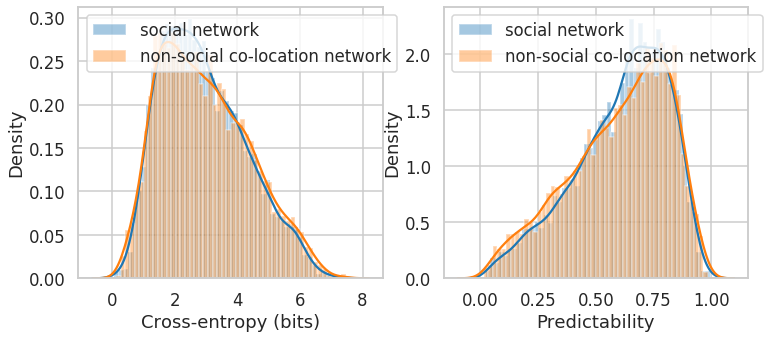

In [51]:
CE_v3 = compare_v3.plot_histogram(l=12,w=5)

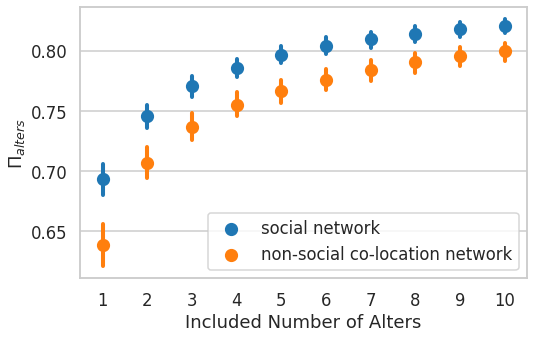

In [52]:
CCP_alters_errorbar_v3 = compare_v3.plot_errorbar(target='CCP alters', l=8,w=5)

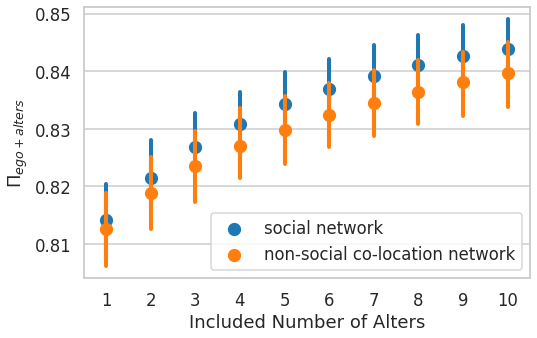

In [53]:
CCP_ego_alters_errorbar_v3 = compare_v3.plot_errorbar(target='CCP ego+alters', l=8,w=5)

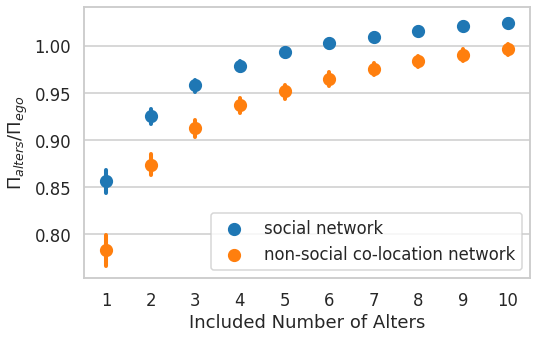

In [54]:
RCCP_alters_errorbar_v3 = compare_v3.plot_errorbar(target="RCCP alters", l=8,w=5)

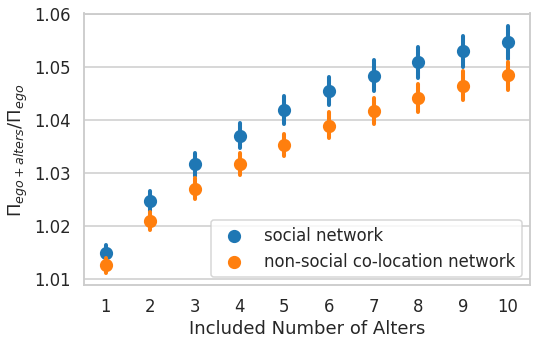

In [55]:
RCCP_ego_alters_errorbar_v3 = compare_v3.plot_errorbar(target='RCCP ego+alters', l=8,w=5)

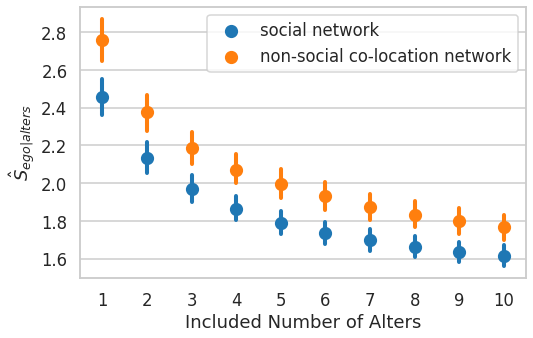

In [56]:
CCE_alters_errorbar_v3 = compare_v3.plot_errorbar(target='CCE alters', l=8,w=5)

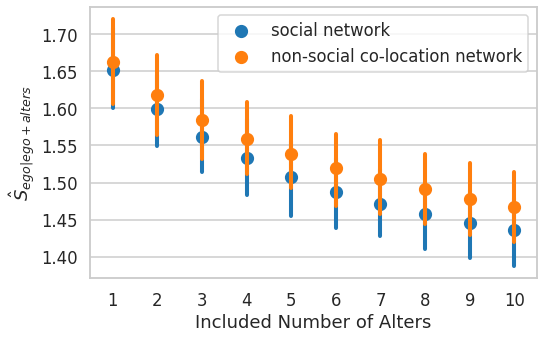

In [57]:
CCE_ego_alters_errorbar_v3 = compare_v3.plot_errorbar(target='CCE ego+alters', l=8,w=5)

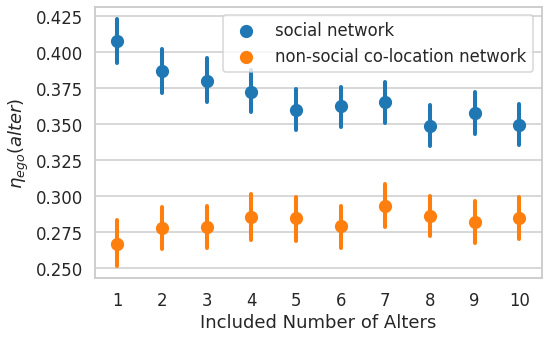

In [58]:
ODLR_errorbar_v3 = compare_v3.plot_errorbar(target='ODLR', l=8,w=5)

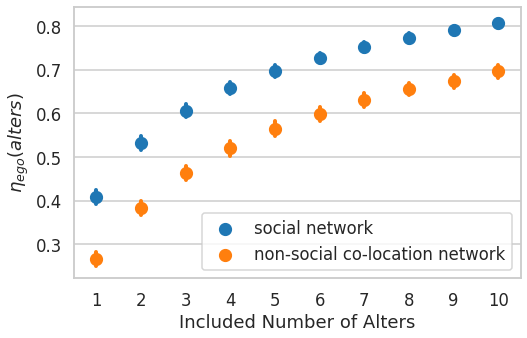

In [59]:
CODLR_errorbar_v3 = compare_v3.plot_errorbar(target='CODLR', l=8,w=5)

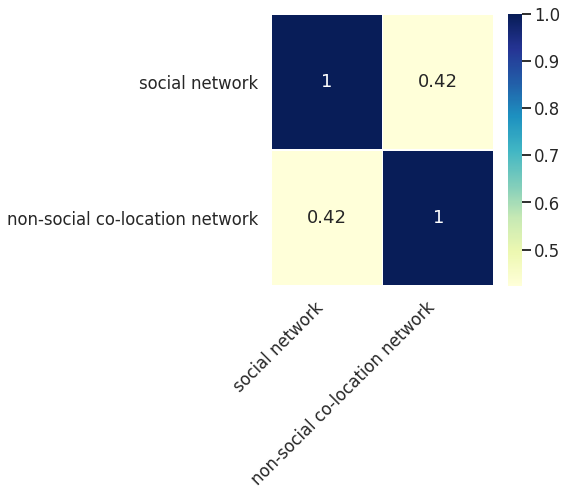

In [60]:
local_sim_v3 = compare_v3.plot_similarity(local=False, l=5,w=5)

In [61]:
compare_v3.statistics.to_csv('BZR_reciprocal_15_stats_non_social_vs_social.csv', index=False)

In [62]:
compare_v3.data.to_csv('BZR_reciprocal_15_common_top10_details.csv', index=False)